# Tutorial 3: Initialisation of Metastable He Excitation with Data

In this tutorial a more relaistic system will be simulated which could be the process in an experiment. Let's say that helium is excited to a metastable D-state via electron impact from its ground state whilst a laser excites these electron-excited atoms into a high-lying P-state. A level diagram of the system is shown below.

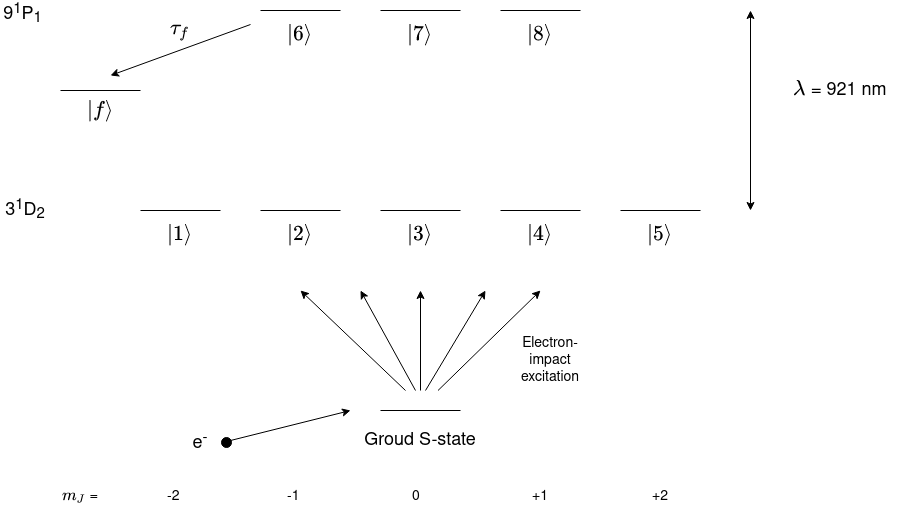

In [1]:
from IPython.display import Image
Image(filename = "LevelDiagrams/HeMetastableStateExcitation.png")

Let's import all the libraries needed. We will need a library to read in data from a datafile. `pandas` is a good library to do this.

In [2]:
import LASED as las
import numpy as np
import plotly.graph_objects as go
import pandas as pd  #This librray is used to read in the data

## Setting up the System

This is a very similar system to last tutorial except for the lifetime and laser wavelength. Both of these values are taken from looking at the transition on the National Institute of Standards and Technology's (NIST) atomic database. The page for He can be found [here](https://physics.nist.gov/cgi-bin/ASD/lines1.pl?spectra=He+I&limits_type=0&low_w=&upp_w=&unit=1&submit=Retrieve+Data&de=0&format=0&line_out=0&en_unit=0&output=0&bibrefs=1&page_size=15&show_obs_wl=1&show_calc_wl=1&unc_out=1&order_out=0&max_low_enrg=&show_av=3&max_upp_enrg=&tsb_value=0&min_str=&A_out=0&intens_out=on&max_str=&allowed_out=1&forbid_out=1&min_accur=&min_intens=&conf_out=on&term_out=on&enrg_out=on&J_out=on). 

In [3]:
# System parameters
n = 8  # number of energy levels in system

tau = 57.7e3 # lifetime in ns (take from NIST 1/A_ki as this is in rad/s)
tau_f = 100e3 # estimated non-radiative lifetime of rydberg upper state to other states in ns/rad
laser_wavelength = 921.287e-9 # wavelength of laser 3D to 9P state from NIST

w_e = las.angularFreq(laser_wavelength)  # Converted to angular frequency in Grad/s

# Create states for J = 2 -> J = 1
one = las.State(L = 2, S = 0, m = -2, w = 0, label = 1)
two = las.State(L = 2, S = 0, m = -1, w = 0, label = 2)
three = las.State(L = 2, S = 0, m = 0, w = 0, label = 3)
four = las.State(L = 2, S = 0, m = 1, w = 0, label = 4)
five = las.State(L = 2, S = 0, m = 2, w = 0, label = 5)
six = las.State(L = 1, S = 0, m = -1, w = w_e, label = 6)
seven = las.State(L = 1, S = 0, m = 0, w = w_e, label = 7)
eight = las.State(L = 1, S = 0, m = 1, w = w_e, label = 8)

G = [one, two, three, four, five] # ground states
E = [six, seven, eight] # excited states
Q = [0] # laser radiation polarisation]

# Simulation parameters
start_time = 0
stop_time = 1000 # in ns
steps = 1001
time = np.linspace(start_time, stop_time, steps)

# Laser parameters
laser_power = 100 # laser intensity in mW
r_sigma = 0.75  # radial distance to 2D standard deviation in mm
n_intensity = 20

# Doppler detuning parameters
doppler_width = 0.1*2*np.pi # doppler width in Grad/s
delta_upper = 3*doppler_width
delta_lower = -3*doppler_width
doppler_steps = 20
doppler_detunings = np.linspace(delta_lower, delta_upper, doppler_steps)
atomic_velocity = 0  # Velocity component of atoms in direction of laser beam in m/s

Next, make the `LaserAtomSystem`.

In [4]:
helium_system = las.LaserAtomSystem(E, G, tau, Q, laser_wavelength, tau_f = tau_f, 
                                 laser_power = laser_power)

## Initialisating the Laser-Atom System with Data

Now, we need to extract the data from the datafile. This is scattering amplitude data kindly given by Igor Brey who has calculated these amplitudes from a model. The model is quite accurate for helium and gives amplitudes for various impact angles. 

Igor calculated electron impact excitation amplitudes for all angles to the 3$^1$D state. With this data we can generate an initial density matrix to excite from real data. The data was generated in the collison frame.

The density matrix elements correspond to </br>
$\rho_{M,M'} = \sum_{m'}{\langle}Mm'_f|\rho_f|M'm'_f{\rangle}$ </br>
           $ = {\langle}f(M)f^*(M'){\rangle} = \sigma(M)$
           
where $f(M)$ is the scattering amplitude for state $|J M \rangle$. 

Select data from the scattering angle of 45 degrees.

In [5]:
scat_data = pd.read_csv("Igor31DAmplitudes.csv")
scat_angle_data = scat_data.loc[scat_data['Angle'] == 45]
print(scat_angle_data)

    Angle  Re a(+2)*1e-12  Im(a+2)*1e-12  Re a(+1)*1e-12  Im(a+1)*1e-12  \
45     45           8.821           19.5           14.84         -35.66   

    Re a(0)*1e-12  Im(a0)*1e-12  Re(a-1)*1e-12  Im(a-1)*1e-12  Re(a-2)*1e-12  \
45          85.82        -12.27         -14.84          35.66          8.821   

    Im(a-2)*1e-12  
45           19.5  


Now we have read in what values the amplitudes are and we can now obtain the diagonal density matrix elements. First, put the scattering amplitudes in variables and put them into a list. 

In [6]:
f_2 = scat_angle_data.iloc[0].at["Re a(+2)*1e-12"] + scat_angle_data.iloc[0].at["Im(a+2)*1e-12"]*1.j
f_1 = scat_angle_data.iloc[0].at["Re a(+1)*1e-12"] + scat_angle_data.iloc[0].at["Im(a+1)*1e-12"]*1.j
f_0 = scat_angle_data.iloc[0].at["Re a(0)*1e-12"] + scat_angle_data.iloc[0].at["Im(a0)*1e-12"]*1.j
f_minus1 = scat_angle_data.iloc[0].at["Re(a-1)*1e-12"] + scat_angle_data.iloc[0].at["Im(a-1)*1e-12"]*1.j
f_minus2 = scat_angle_data.iloc[0].at["Re(a-2)*1e-12"] + scat_angle_data.iloc[0].at["Im(a-2)*1e-12"]*1.j
f = [f_minus2, f_minus1, f_0, f_1, f_2]

Now, calculate the density matrix $\rho$. Normalise the populations so that tr(𝜌) = 1.

**Note**: The density matrix created must be in the order with the value of $\rho_{-m, -m}$ starting the upper left-hand side of the matrix to $\rho_{m, m}$ at the bottom right-hand corner. $m$ is the projection of the total angular momentum.

In [7]:
rho_collision = np.zeros((len(G), len(G)), dtype = complex)

for i, population in enumerate(f):
    for j, population in enumerate(f):
        rho_collision[i][j] = f[i]*np.conj(f[j])

# Normalisation
norm = 0
for i in range(len(G)):
    norm += rho_collision[i][i]
rho_collision = rho_collision/norm
print("The J = 2 density matrix in the collision frame is \n", pd.DataFrame(np.flip(rho_collision)))

The J = 2 density matrix in the collision frame is 
                     0                   1                   2  \
0  0.040126+0.000000j -0.049448+0.052905j  0.045355+0.156080j   
1 -0.049448-0.052905j  0.130688+0.000000j  0.149895-0.252136j   
2  0.045355-0.156080j  0.149895+0.252136j  0.658372+0.000000j   
3  0.049448+0.052905j -0.130688+0.000000j -0.149895+0.252136j   
4  0.040126+0.000000j -0.049448+0.052905j  0.045355+0.156080j   

                    3                   4  
0  0.049448-0.052905j  0.040126+0.000000j  
1 -0.130688+0.000000j -0.049448-0.052905j  
2 -0.149895-0.252136j  0.045355-0.156080j  
3  0.130688+0.000000j  0.049448+0.052905j  
4  0.049448-0.052905j  0.040126+0.000000j  


**Note**: Above `pandas` is used to convert the matrix into a `DataFrame` just for display purposes and the display of a matrix as a DataFrame is neater and the indeces are easier to read.

Now, we must initialise the density matrix of the `LaserAtomSystem` with this calculated ground state density matrix. To do this, we can use the function `appendDensityMatrixToRho_0(density_rho)` where:
* `rho_0` is a column vector which is of size n$^2$, where n is the number of energy levels in the system. This column vector represents the denisty matrix for the laser-atom system. It is flattened (one-dimensional) as it is easier to solve the equations of motion generated with this form. It is in the form of:
$$
\rho_{flattened} = \begin{bmatrix} \rho_{11} \cr \rho_{12} \cr . \cr . \cr \rho_{1n} \cr \rho_{21} \cr . \cr . \cr \rho_{nn}\end{bmatrix}
$$

* `density_rho` is the density matrix of the ground or upper state density matrix to be input into the flattened coupled denisty matrix and then initialised as `rho_0` in the `LaserAtomSystem`. This is of type `ndarray`. This is a usual 2D matrix.

`rho_0` is already initialised as empty with the correct size when a `LaserAtomSystem` is initialised.

In [8]:
helium_system.appendDensityMatrixToRho_0(rho_collision)
print("The initial ρ for the laser-atom system is: \n", helium_system.rho_0)

The initial ρ for the laser-atom system is: 
 [[ 0.04012626+0.j        ]
 [ 0.0494475 -0.05290513j]
 [ 0.04535541+0.15607978j]
 [-0.0494475 +0.05290513j]
 [ 0.04012626+0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.0494475 +0.05290513j]
 [ 0.1306877 +0.j        ]
 [-0.1498946 +0.25213635j]
 [-0.1306877 +0.j        ]
 [ 0.0494475 +0.05290513j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.04535541-0.15607978j]
 [-0.1498946 -0.25213635j]
 [ 0.65837208+0.j        ]
 [ 0.1498946 +0.25213635j]
 [ 0.04535541-0.15607978j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.0494475 -0.05290513j]
 [-0.1306877 +0.j        ]
 [ 0.1498946 -0.25213635j]
 [ 0.1306877 +0.j        ]
 [-0.0494475 -0.05290513j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.04012626+0.j        ]
 [ 0.0494475 -0.05290513j]
 [ 0.04535541+0.15607978j]
 [-0.0494

## Time Evolution

Time evolve the helium system.

In [9]:
helium_system.timeEvolution(time, 
                            r_sigma = r_sigma,
                            n_beam_averaging = n_intensity,
                            doppler_width = doppler_width,
                            doppler_detunings = doppler_detunings,
                            beam_profile_averaging = True,
                            doppler_averaging = True)

## Plotting and Saving Data

Now, save and plot the data.

In [10]:
helium_system.saveToCSV("SavedData/MetastableHeBrey100mWDopplerWidth100MHzTEM00Averaged.csv")

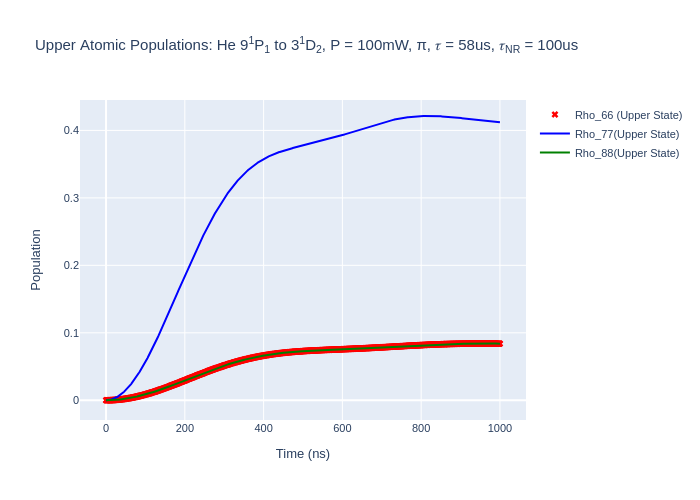

In [17]:
rho_66 = [ abs(rho) for rho in helium_system.Rho_t(six, six)]
rho_77 = [abs(rho) for rho in helium_system.Rho_t(seven, seven)]
rho_88 = [abs(rho) for rho in helium_system.Rho_t(eight, eight)]

fig_upper = go.Figure(data = go.Scatter(x = time,
                                 y = rho_66,
                                 mode = 'markers',
                                    name = "Rho_66 (Upper State)",
                                    marker = dict(
                                color = 'red',
                                symbol = 'x',
                            )))

fig_upper.add_trace(go.Scatter(x = time,
                                 y = rho_77,
                                 mode = 'lines',
                                    name = "Rho_77(Upper State)",
                                    marker = dict(
                                color = 'blue',
                                symbol = 'square',
                           )))
fig_upper.add_trace(go.Scatter(x = time,
                                 y = rho_88,
                                 mode = 'lines',
                                    name = "Rho_88(Upper State)",
                                    marker = dict(
                                color = 'green',
                                symbol = 'circle',
                           )))

fig_upper.update_layout(title = "Upper Atomic Populations: He 9<sup>1</sup>P<sub>1</sub> to 3<sup>1</sup>D<sub>2</sub>, P = {:0.0f}mW, π, 𝜏 = {:0.0f}us, 𝜏<sub>NR</sub> = {:0.0f}us".format(laser_power, tau/1e3, tau_f/1e3),
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))

fig_upper.write_image("SavedPlots/tutorial3-HeFigUpper.png")
Image("SavedPlots/tutorial3-HeFigUpper.png")

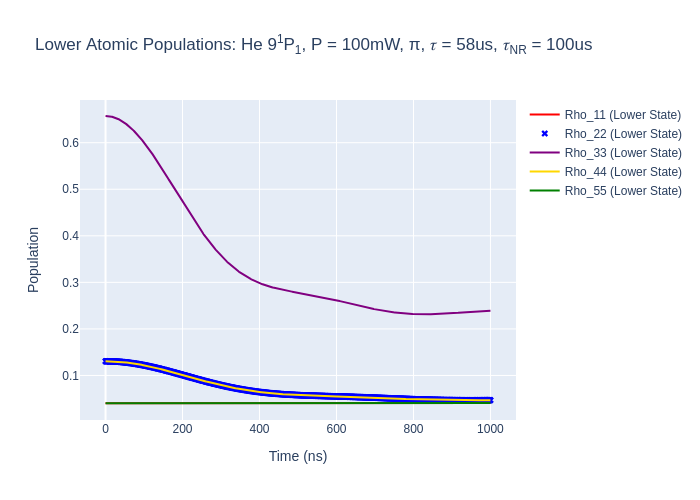

In [16]:
rho11 = [ abs(rho) for rho in helium_system.Rho_t(one, one)]
rho22 = [ abs(rho) for rho in helium_system.Rho_t(two, two)]
rho33 = [ abs(rho) for rho in helium_system.Rho_t(three, three)]
rho44 = [ abs(rho) for rho in helium_system.Rho_t(four, four)]
rho55 = [ abs(rho) for rho in helium_system.Rho_t(five, five)]


fig_lower = go.Figure(data = go.Scatter(x = time,
                                 y = rho11,
                                 mode = 'lines',
                                    name = "Rho_11 (Lower State)",
                                    marker = dict(
                                color = 'red',
                                symbol = 'circle',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho22,
                                 mode = 'markers',
                                    name = "Rho_22 (Lower State)",
                                    marker = dict(
                                color = 'blue',
                                symbol = 'x',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho33,
                                 mode = 'lines',
                                    name = "Rho_33 (Lower State)",
                                    marker = dict(
                                color = 'purple',
                                symbol = 'x',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho44,
                                 mode = 'lines',
                                    name = "Rho_44 (Lower State)",
                                    marker = dict(
                                color = 'gold',
                                symbol = 'x',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho55,
                                 mode = 'lines',
                                    name = "Rho_55 (Lower State)",
                                    marker = dict(
                                color = 'green',
                                symbol = 'square',
                            )))
fig_lower.update_layout(title = "Lower Atomic Populations: He 9<sup>1</sup>P<sub>1</sub>, P = {:0.0f}mW, π, 𝜏 = {:0.0f}us, 𝜏<sub>NR</sub> = {:0.0f}us".format(laser_power, tau/1e3, tau_f/1e3),
                        xaxis_title = "Time (ns)",
                        yaxis_title = "Population")

fig_lower.write_image("SavedPlots/tutorial3-HeFigLower.png")
Image("SavedPlots/tutorial3-HeFigLower.png")